In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM , Bidirectional , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



In [2]:
df = pd.read_csv('/content/emotion_dataset.csv')
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+','',text)
    text = re.sub(r'@\w+','',text)
    text = re.sub(r'#\w+','',text)
    text = re.sub(r'[^a-z\s]','',text)
    text = re.sub(r'\s+',' ',text).strip()
    return text

df['text'] = df['text'].astype(str).apply(preprocess_text)


In [4]:
# Label Encoding Emotion
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

In [5]:
df.head()

,text,label
0,i didnt feel humiliated,3
1,i can go from feeling so hopeless to so damned...,3
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,0


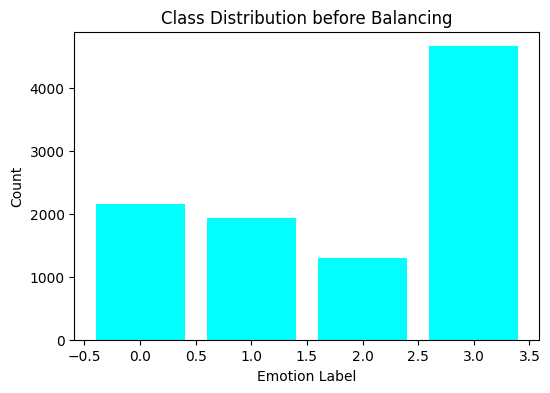

In [6]:
plt.figure(figsize=(6,4))
plt.bar(Counter(df['label']).keys(), Counter(df['label']).values(),
            color = 'cyan')
plt.title("Class Distribution before Balancing")
plt.xlabel("Emotion Label")
plt.ylabel('Count')
plt.show()

In [7]:
# Text into Numerical Sequence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
vocab_size = len(tokenizer.word_index)+1
max_length = 100

# Padding to make equal
X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=max_length , padding='post')
y = df['label'].values

In [8]:
# Balancing using Random Sampler
ros = RandomOverSampler(random_state=42)
X_resampled , y_resampled = ros.fit_resample(X,y)

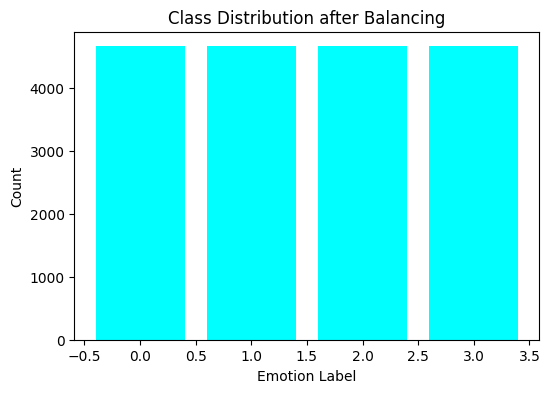

In [9]:
plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values(),
            color = 'cyan')
plt.title("Class Distribution after Balancing")
plt.xlabel("Emotion Label")
plt.ylabel('Count')
plt.show()

In [10]:
# Train Test Split
X_train , X_test , y_train , y_test = train_test_split(X_resampled, y_resampled , random_state=42 , test_size=0.2)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((14931, 100), (3733, 100), (14931,), (3733,))

In [11]:
# Model Building
model = Sequential([

    # Words -> Dense Vectors : To understand relationship
    Embedding(input_dim=vocab_size , output_dim=200 , input_length = max_length),

    # To use both sides for better understanding
    Bidirectional(LSTM(128, return_sequences=True)),

    # Remove Overfitting and ensure smooth training
    BatchNormalization(),

    # Dropping 30% of the neurons and prevent overfitting
    Dropout(0.3),

    # Final LSTM vector before FCL
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),

    # Fully Connected Dense Layer
    Dense(32, activation='relu'),
    BatchNormalization(),

    # Final Output Layer doing Multi Class Classification
    Dense(len(np.unique(y_resampled)), activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compiling and Learning
model.compile(optimizer = Adam(learning_rate=0.001),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

history = model.fit(X_train,y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.4119 - loss: 1.4088 - val_accuracy: 0.8032 - val_loss: 0.4972
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9468 - loss: 0.1781 - val_accuracy: 0.9444 - val_loss: 0.1977
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9722 - loss: 0.0939 - val_accuracy: 0.9598 - val_loss: 0.1422
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9839 - loss: 0.0601 - val_accuracy: 0.9558 - val_loss: 0.1852
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9894 - loss: 0.0414 - val_accuracy: 0.9692 - val_loss: 0.1444
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9870 - loss: 0.0435 - val_accuracy: 0.9665 - val_loss: 0.1570
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9924 - loss: 0.0276 - val_accuracy: 0.9632 - val_loss: 0.1695
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9895 - loss: 0.0390 - 

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 200)       │     2,290,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,392,254 (32.01 MB)

 Trainable params: 2,797,140 (10.67 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 5,594,282 (21.34 MB)

In [14]:
test_loss , test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
print(f"Test Accuracy : {test_accuracy:.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9773 - loss: 0.0920
Test Accuracy : 0.9700


In [15]:
import joblib

model.save("emotion_detection.h5")

joblib.dump(tokenizer, "tokenizer.jb")
joblib.dump(label_encoder , "label_encoder.jb")

['label_encoder.jb']